# Préparation dataset

## Récupération du dataset et filtres de données

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fichier des tweets à récupérer sur :
# https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+prétraitement+textes+images.zip
data_T0 = pd.read_csv(
    "Flipkart/flipkart_com-ecommerce_sample_1050.csv", index_col=['uniq_id'])

## Cleaning data

In [3]:
data_T = pd.DataFrame(
    data_T0[['image', 'product_category_tree', 'description']])

In [4]:
# Tokenizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim


def tokenizer_fct(_sentence):  # function to tokenize a sentence
    sentence_clean = _sentence.replace('-', ' ').replace('+', ' ')\
        .replace('/', ' ').replace('#', ' ').replace('.', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens


def stop_word_filter_fct(list_words):  # function to delete stop words
    stop_words = list(set(stopwords.words('english'))) + \
        ['[', ']', ',', ':', '?', '(', ')', '!']
    filtered_w = [w for w in list_words if not w in stop_words]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2


def lower_fct(list_words):  # lower case et alpha
    lw = [w.lower() for w in list_words]
    return lw


def lemma_fct(list_words):  # Lemmatizer (base d'un mot)
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_lower_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_sw_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    transf_desc_text = ' '.join(sw)
    return transf_desc_text


# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_sw_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    lem_w = lemma_fct(sw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


data_T['description_lower'] = data_T0['description'].apply(
    lambda x: transform_lower_fct(x))

data_T['description_sw'] = data_T0['description'].apply(
    lambda x: transform_sw_fct(x))

data_T['description_sw_lem'] = data_T0['description'].apply(
    lambda x: transform_sw_lem_fct(x))

# Analyze dataset

## Category count

                            0
0             Home Furnishing
1                   Baby Care
2                     Watches
3  Home Decor & Festive Needs
4            Kitchen & Dining
5    Beauty and Personal Care
6                   Computers


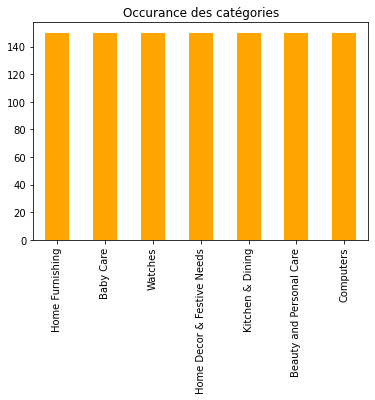

In [5]:
from sklearn import preprocessing


def get_category(_cat_tree):
    categories_list = _cat_tree.replace(
        '["', '').replace('"]', '').split(' >> ')
    return " ".join(categories_list[:1])


# Create categories from product_category_tree column
data_T['category'] = data_T['product_category_tree'].apply(
    lambda cat_tree: get_category(cat_tree))

# Plot articles count for each category
data_T['category'].value_counts().plot.bar(
    rot=90, title='Occurance des catégories', color=["orange"])

print(pd.DataFrame(data_T['category'].unique()))

# Encode category in int
data_T['category_label'] = preprocessing.LabelEncoder(
).fit_transform(data_T['category'])

## Count words number and unique words number by category

In [6]:
import nltk
from collections import defaultdict

def freq_stats_corpora(_dictionary):
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par catégories
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    for category, descriptions in _dictionary.items():
        for description in descriptions:
            corpora[category] += lower_fct(tokenizer_fct(description))

    stats = dict()
    for k, v in corpora.items():
        fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}

    stats_df = pd.DataFrame.from_dict(stats, orient='index')

    return stats_df

<AxesSubplot:title={'center':'Nombre de mots par catégories'}>

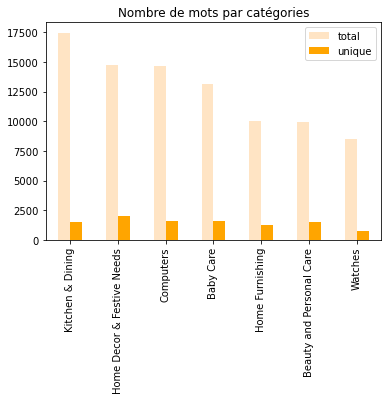

In [7]:
# Create a dictionary with descriptions list for each category
descriptions_dict = defaultdict(set)
for index, row in data_T.iterrows():
    descriptions_dict[row['category']].add(row['description_lower'])

# Récupération des comptages
stats_df_des = freq_stats_corpora(descriptions_dict)

# Affichage des fréquences
stats_df_des = stats_df_des.sort_values(by='total', ascending=False)
stats_df_des.plot(kind='bar', color=["bisque", "orange"],
              title='Nombre de mots par catégories')

## Comparaison words count between normal, whithout stopwords and lemmatize description 

<AxesSubplot:title={'center':'Nombre de mots uniques par catégories'}>

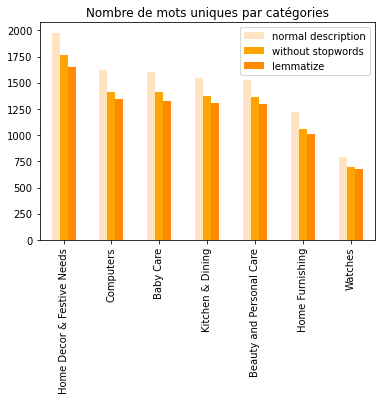

In [8]:
from nltk.corpus import stopwords

# Without stop words description words count
descriptions_sw_dict = defaultdict(set)
for index, row in data_T.iterrows():
    descriptions_sw_dict[row['category']].add(row['description_sw'])
stats_df_sw = freq_stats_corpora(descriptions_sw_dict)

# Lemmatize description words count
descriptions_lem_dict = defaultdict(set)
for index, row in data_T.iterrows():
    descriptions_lem_dict[row['category']].add(row['description_sw_lem'])
stats_df_lem = freq_stats_corpora(descriptions_lem_dict)

# Affichage des fréquences
stats_df_des = stats_df_des.sort_values(by='unique', ascending=False)
df = pd.concat([stats_df_des['unique'], stats_df_sw['unique'], stats_df_lem['unique']],
               axis=1, keys=['normal description', 'without stopwords', 'lemmatize'])

df.plot(kind='bar', color=["bisque", "orange", "darkorange"],
        title='Nombre de mots uniques par catégories')

# Define common functions

In [9]:
import time
from sklearn import manifold


# TSNE visualization of data with categorical colorization
def TSNE_visu(_data, _category_label, _ax):
    # Create TSNE decomposer
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    # Decompose bag of words features using TNSE
    X_tsne = tsne.fit_transform(_data)

    # Data visualization
    scatter = _ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=_category_label, cmap='Set1')
    _ax.legend(handles=scatter.legend_elements()[0], labels=list(
        set(_category_label)), loc="best", title="Categories", fontsize=15, title_fontsize=15)
    return

# Tf-idf

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

# Refine min-max words frequency for Tf-idf vectorizer
silhouette_df = pd.DataFrame()
for max_value in range(100, 1001, 100):
    for min_value in range(1, 101, 10):
        tf_vec = TfidfVectorizer(stop_words='english',
                                 min_df=min_value, 
                                 max_df=max_value, 
                                 ngram_range=(2, 2))
        data_transform = tf_vec.fit_transform(data_T['description_lower'])
        silhouette_df.loc[min_value, max_value] = silhouette_score(
            data_transform, data_T['category_label'])

silhouette_min_max_loc = silhouette_df.stack().idxmax()

print('silhouette : optimal min max words frequency :', silhouette_min_max_loc)
print('optimal silhouette value :', silhouette_df.stack().max())

silhouette : optimal min max words frequency : (71, 300)
optimal silhouette value : 0.198313101761059


In [19]:
print(silhouette_df)

        100       200       300       400       500       600       700   \
1   0.013454  0.016011  0.016288  0.016066  0.016000  0.015532  0.015532   
11  0.048772  0.069157  0.092876  0.090226  0.087565  0.083837  0.083837   
21  0.036373  0.084448  0.126619  0.122519  0.121121  0.116108  0.116108   
31  0.023796  0.082766  0.150571  0.144855  0.143126  0.136470  0.136470   
41  0.045711  0.106171  0.167435  0.163040  0.160412  0.153712  0.153712   
51  0.044201  0.114836  0.177393  0.171619  0.169204  0.162282  0.162282   
61  0.036778  0.130598  0.187169  0.179035  0.176464  0.169604  0.169604   
71 -0.170248  0.146444  0.198313  0.186976  0.185162  0.178265  0.178265   
81 -0.479848  0.061570  0.126636  0.125477  0.125725  0.123278  0.123278   
91 -0.317553  0.048931  0.105734  0.108307  0.109057  0.105377  0.105377   

        800       900       1000  
1   0.015532  0.015532  0.015532  
11  0.083837  0.083837  0.083837  
21  0.116108  0.116108  0.116108  
31  0.136470  0.136470 

(1050, 483)


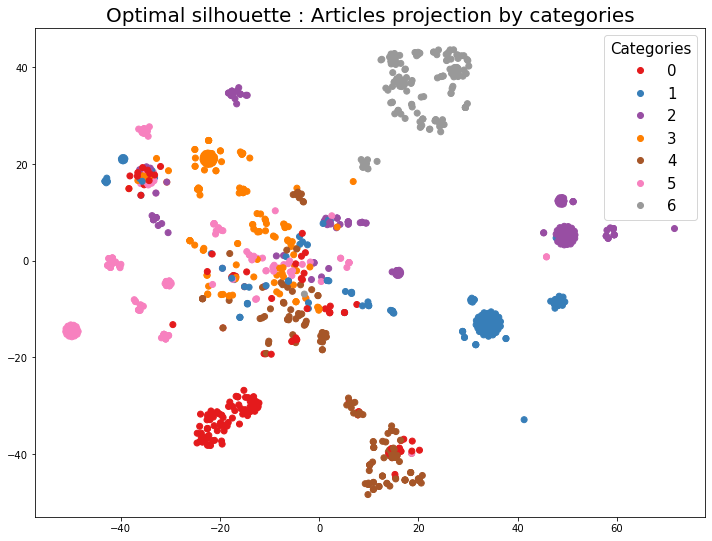

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec = TfidfVectorizer(stop_words='english',
                         min_df=silhouette_min_max_loc[0], 
                         max_df=silhouette_min_max_loc[1], 
                         ngram_range=(2, 2))
data_transform = tf_vec.fit_transform(data_T['description_lower'])
print(data_transform.todense().shape)

# Display TSNE on optimal min-max words frequency
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(data_transform, data_T['category_label'], ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Bag of words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

silhouette_df = pd.DataFrame()

for max_value in range(100, 1001, 100):
    for min_value in range(1, 101, 10):
        tf_vec = CountVectorizer(stop_words='english',
                                 min_df=min_value, 
                                 max_df=max_value, 
                                 ngram_range=(2, 2))
        data_transform = tf_vec.fit_transform(data_T['description_sw_lem'])
        silhouette_df.loc[min_value, max_value] = silhouette_score(
            data_transform, data_T['category_label'])

silhouette_min_max_loc = silhouette_df.stack().idxmax()

print('silhouette : optimal min max words frequency :', silhouette_min_max_loc)
print('optimal silhouette value :', silhouette_df.stack().max())

silhouette : optimal min max words frequency : (71, 300)
optimal silhouette value : 0.15817060882461564


(1050, 24)


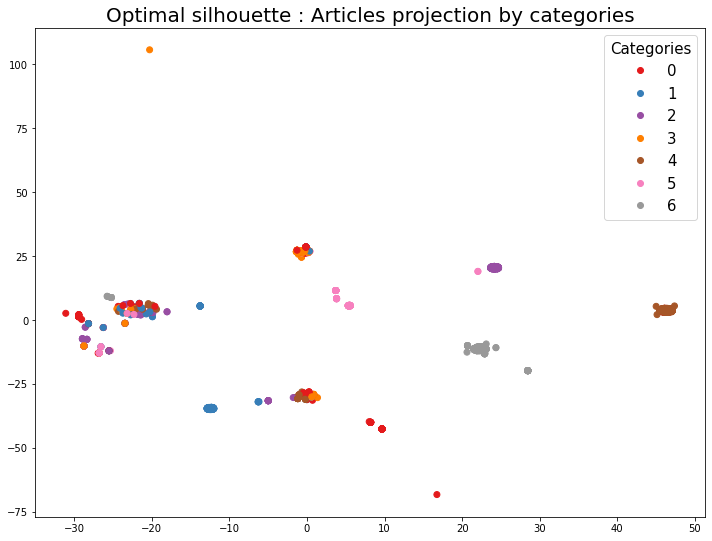

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vec = CountVectorizer(stop_words='english',
                         analyzer='word',
                         min_df=silhouette_min_max_loc[0],
                         max_df=silhouette_min_max_loc[1],
                         ngram_range=(2, 2))
data_transform = tf_vec.fit_transform(data_T['description_lower'])
print(data_transform.todense().shape)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(data_transform, data_T['category_label'], ax)
ax.set_title(
    'Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Word2Vec

## Define function

In [14]:
import multiprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

maxlen = 24  # adapt to length of sentences


def process_word2Vec(_sentences, _min_count, _window, _size, _epochs):
    # build and train Word2Vec model
    w2v_model = gensim.models.Word2Vec(min_count=_min_count,
                                       window=_window,
                                       vector_size=_size,
                                       seed=42,
                                       workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(_sentences)
    w2v_model.train(
        _sentences, total_examples=w2v_model.corpus_count, epochs=_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key

    # Préparation des sentences (tokenization)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(_sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(_sentences),
                                maxlen=maxlen,
                                padding='post')

    num_words = len(tokenizer.word_index) + 1

    # Création de la matrice d'embedding
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, _size))
    i = 0
    j = 0

    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i, 4)

    # Création du modèle d'embedding
    input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
    word_input = Input(shape=(maxlen,), dtype='float64')
    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=_size,
                               weights=[embedding_matrix],
                               input_length=maxlen)(word_input)
    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    # Exécution du modèle
    embeddings = embed_model.predict(x_sentences)

    return embeddings

## Get optimal parameters

In [15]:
from sklearn.metrics import silhouette_score

sentences = data_T['description_sw_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

epochs = 20
size = 250

silhouette_max = -float('inf')
for min_count in range(2, 28, 5):
    for window in range(200, 1001, 200):
#        for size in range(50, 301, 50):
#            for epochs in range(10, 31, 10):
        embeddings = process_word2Vec(
            sentences, min_count, window, size, epochs)

        silhouette = silhouette_score(embeddings, data_T['category_label'])
        if silhouette > silhouette_max:
            silhouette_max = silhouette
            min_count_opt = min_count
            window_opt = window
            size_opt = size
            epochs_opt = epochs

print('optimal min_count :', min_count_opt)
print('optimal window :', window_opt)
print('optimal size :', size_opt)
print('optimal epochs :', epochs_opt)
print('optimal silhouette value :', silhouette_max)

2022-06-03 08:11:45.809273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


33/33 [==============================] - 0s 1ms/step
optimal min_count : 2
optimal window : 400
optimal size : 250
optimal epochs : 20
optimal silhouette value : 0.08206008


## Visualization word2Vec with optimal parameters

Word2Vec silhouette score : 0.08175748
WordToVec : 
(1050, 250)


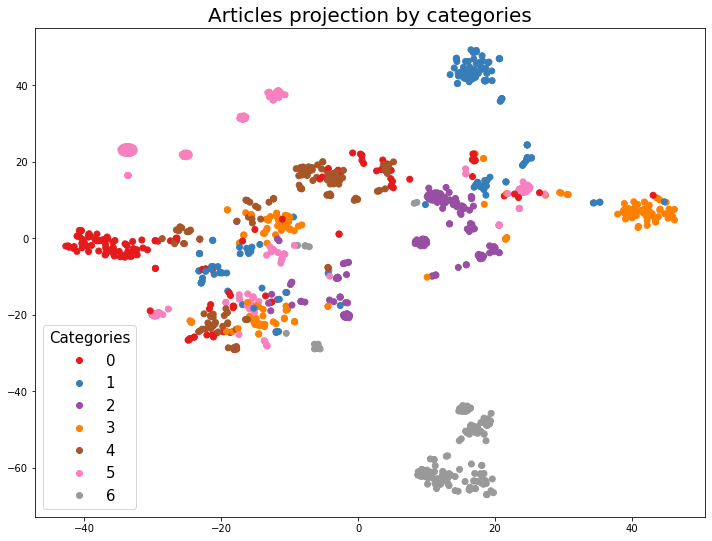

In [19]:
import gensim

sentences = data_T['description_sw_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

embeddings = process_word2Vec(
    sentences, min_count_opt, window_opt, size_opt, epochs_opt)

print("Word2Vec silhouette score :",
      silhouette_score(embeddings, data_T['category_label']))

print("WordToVec : ")
print(embeddings.shape)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(embeddings, data_T['category_label'], ax)
ax.set_title('Articles projection by categories', fontsize=20)
plt.show()

# LDA-NMF

In [20]:
def display_topics(_model, _feature_names, _no_top_words):
    for topic_idx, topic in enumerate(_model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([_feature_names[i] for i in topic.argsort()[:-_no_top_words - 1:-1]]))

In [78]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# création du bag of words (CountVectorizer et Tf-idf)
tf_vectorizer = CountVectorizer(stop_words='english', max_df=0.85, min_df=2)
tf = tf_vectorizer.fit_transform(data_T['description_sw_lem'].to_list())

n_topics = 10

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

word_features = lda.transform(tf)
# Faire TSNE

no_top_words = 15
display_topics(lda, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
laptop warranty shape skin mouse pad print combo multicolor set type feature inch specification color
Topic 1:
quality battery product oil art bowl price high beautiful beauty handmade lapguard replacement oxyglow fruit
Topic 2:
single cover sheet bedsheet cotton bed double inch quilt pillow print comforter floral flat king
Topic 3:
product adapter light warranty use price power usb replacement size quality feature key bowl place
Topic 4:
soap kit mxofere honey aloevera almond jasmine rose papaya frame photo mixfruit 285 lemon combo
Topic 5:
free product delivery buy genuine shipping cash day replacement guarantee flipkart com online watch analog
Topic 6:
pack design skin color feature type box specification number sticker model wall sale package general
Topic 7:
mug ceramic coffee perfect gift design material safe home tea product price loved rockmantra bring
Topic 8:
baby girl fabric cotton boy dress sleeve ideal neck specification general pattern shirt wash casual
Topic 9:


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tf)

no_top_words = 10
display_topics(nmf, tf_vectorizer.get_feature_names(), no_top_words)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Topic 0:
color feature pack type material box product number dimension model
Topic 1:
mug coffee perfect ceramic bring gift tea quality love printland
Topic 2:
product free delivery genuine shipping cash buy flipkart day guarantee
Topic 3:
adapter warranty vgn vaio replacement power laptop smartpro product charger
Topic 4:
skin laptop print shape mouse pad set inch combo warranty
Topic 5:
baby girl fabric cotton dress boy sleeve neck ideal pattern
Topic 6:
battery quality lapguard laptop replacement high cell including label product
Topic 7:
ceramic mug rockmantra product safe design material come gift size
Topic 8:
cotton cover bedsheet sheet inch pillow double flat width length
Topic 9:
watch analog men great india discount woman dial strap boy


/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# BERT

In [85]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

## Fonctions communes

In [86]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("time : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


time :  97.0
BERT silhouette score : 0.031365275


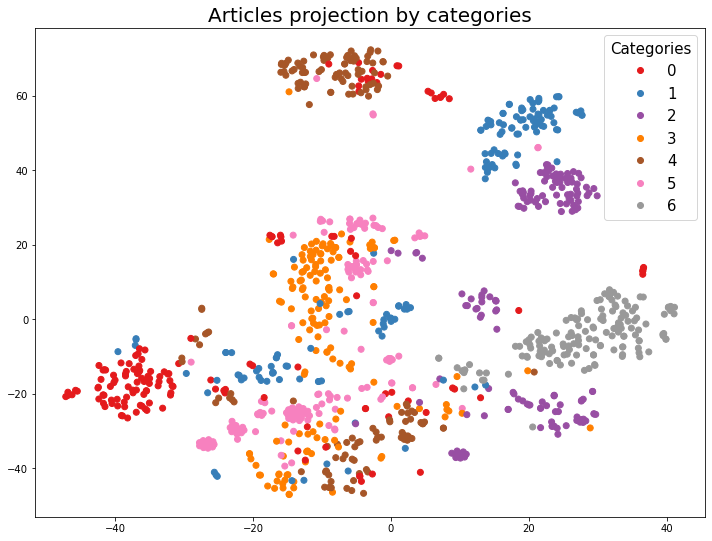

In [87]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['description_sw_lem'].to_list()

# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(
    model, model_type, sentences, max_length, batch_size, mode='HF')
print(features_bert.todense().shape)

print("BERT silhouette score :",
      silhouette_score(features_bert, data_T['category_label']))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(features_bert, data_T['category_label'], ax)
ax.set_title('Articles projection by categories', fontsize=20)
plt.show()

## BERT hub Tensorflow

In [88]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

sentences = data_T['description_low'].to_list()

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

print("BERT silhouette score :",
      silhouette_score(features_bert, data_T['category_label']))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(features_bert, data_T['category_label'], ax)
ax.set_title('Articles projection by categories', fontsize=20)
plt.show()

INFO:absl:Using /var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4, Total size: 429.66MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.


KeyError: 'description_low'

# USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = data_T['description_low'].to_list()

features_USE = feature_USE_fct(sentences, batch_size)

print("USE silhouette score :",
      silhouette_score(features_bert, data_T['category_label']))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(features_USE, data_T['category_label'], ax)
ax.set_title('Articles projection by categories', fontsize=20)
plt.show()